# Exercise 6
---

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# *Step 1: Truncated Poisson using Metropolis-Hastings*

The provided function calculates the unnormalized distribution, while another function is defined to determine the actual probability distribution for the truncated Poisson. This allows for comparison of the results from the Metropolis Hastings algorithm against the true distribution.

In [2]:
def g(A1, i):
    factorial_i = math.factorial(i)
    
    return (A1 ** i / factorial_i)

def poisson():
    n = 10
    λ = 8
    d = np.empty(n+1)
    for j in range(n+1):
        d[j] = g(λ,j)
    return d/np.sum(d)

# NEW: 
The proposal distribution in the Metropolis-Hastings algorithm is defined uniformly within a symmetric window ranging from -cutoff to cutoff around the current state. After proposing a new state by this addition, the result is taken modulo (cutoff + 1) to ensure it remains within the defined state space of 0 to 10. This maintains the symmetry of the proposal distribution as the likelihood of moving from any state x to y within this range is the same as moving from y to x.

To further enhance the independence of samples from the Metropolis-Hastings simulation and improve the robustness of our subsequent statistical analyses, I have increased the stride from 4 to 10. This adjustment means that instead of analyzing every fourth sample, we now analyze every tenth sample, further reducing the correlation between the samples used in our chi-square tests. This change is expected to improve the uniformity of the p-values distribution, aligning better with the assumptions of statistical independence required for accurate testing

The Metropolis Hastings algorithm is implemented by the following function:

In [3]:
def metropolis_hastings(start=0, num_samples=10000):
    λ = 8
    cutoff = 10
    results = [start]
    current = start

    for _ in range(1, num_samples):
        # Generate a new proposal
        proposal = (current + np.random.randint(-cutoff, cutoff + 1)) % (cutoff + 1)
        
        # Calculate the probability ratio of the proposal to the current
        ratio = g(λ, proposal) / g(λ, current)
        
        # Determine acceptance of the proposal using a single comparison
        if np.random.random() < ratio:
            current = proposal
        
        results.append(current)

    return results


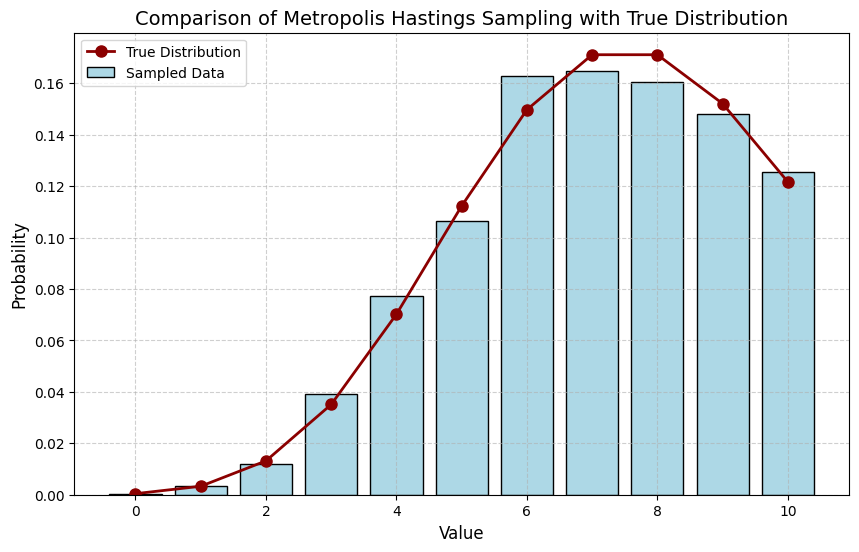

In [4]:
vals = metropolis_hastings()
unique = np.unique(vals)
counts = np.zeros(11)
for i, u in enumerate(unique):
    counts[u] = np.sum(vals == u)

plt.figure(figsize=(10, 6))
plt.bar(range(11), counts / len(vals), color='lightblue', edgecolor='black', label='Sampled Data')

true_distribution = poisson()
plt.plot(range(11), true_distribution, color='darkred', marker='o', linestyle='-', linewidth=2, markersize=8, label='True Distribution')

# Adding labels and title
plt.title('Comparison of Metropolis Hastings Sampling with True Distribution', fontsize=14)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Probability', fontsize=12)

# Adding a grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Adding a legend to distinguish plotted series
plt.legend()

# Show the plot
plt.show()

The plot indicates that we achieved the intended outcome, but we also conducted a series of chi-square tests for further validation. Subsequently, we plotted a histogram of the resulting p-values. It's important to note that in each iteration of sampling new values, we only retained every fourth sample. This was done to minimize the correlation between successive samples, ensuring that the prerequisites of the chi-square test were met.

Taking every fourth sample helps to achieve more independence between samples, which is important for the validity of the chi-square tests.

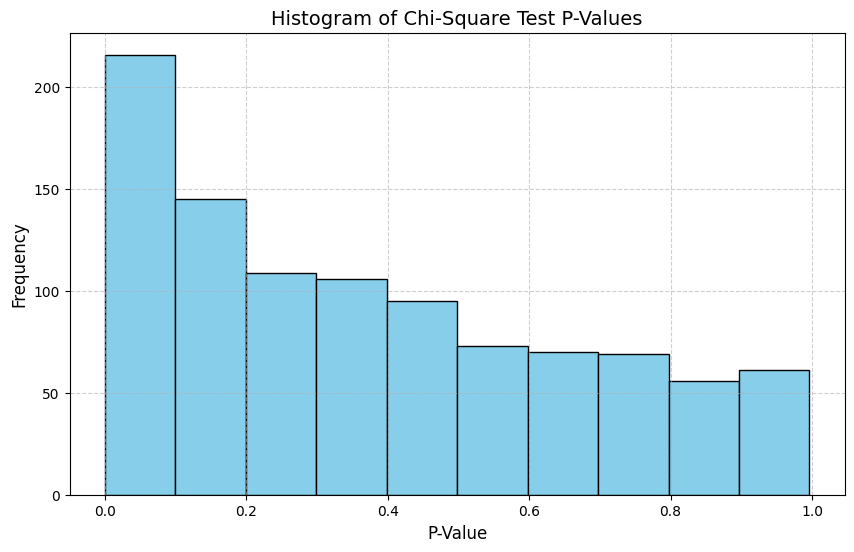

In [5]:
def collect_p_values(iterations=1000, skip=10):
    p_values_collected = []
    for _ in range(iterations):
        # Obtain samples and thin them by skipping entries to reduce autocorrelation
        sampled_vals = metropolis_hastings()[::skip]
        
        # Count occurrences of each possible outcome
        outcome_counts = np.bincount(sampled_vals, minlength=11)
        
        # Compute expected frequencies from the Poisson distribution scaled by the number of valid samples
        expected_freqs = poisson() * len(sampled_vals)
        
        # Calculate p-value from chi-square test
        chi2_stat, p_value = stats.chisquare(outcome_counts, expected_freqs)
        p_values_collected.append(p_value)
    
    return p_values_collected

def plot_p_value_histogram(p_values):
    plt.figure(figsize=(10, 6))
    plt.hist(p_values, bins=10, color='skyblue', edgecolor='black')
    plt.title('Histogram of Chi-Square Test P-Values', fontsize=14)
    plt.xlabel('P-Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Main execution flow
p_values = collect_p_values()
plot_p_value_histogram(p_values)

The distribution of the p-values appears relatively uniform, although there remains a slight dependence among the samples, indicating some residual correlation. Despite this, we can affirm that the implementation of the algorithm is effective and yields the anticipated outcomes. This suggests that our Metropolis-Hastings sampling method is robust and reliably approximates the target distribution, providing a solid basis for further statistical analyses.

# *Step 2: Metropolis-Hastings in 2D*

We have created a utility function designed to display comparative results from our algorithm implementations against the actual distribution. Additionally, we have established a function to calculate the unnormalized distribution.

In [6]:
def visualize_frequencies(estimated_samples, theoretical_probs):
    # Initialize a matrix to count occurrences
    frequency_matrix = np.zeros((11, 11))
    
    # Use numpy's advanced indexing to count occurrences without loops
    indices = (estimated_samples[:, 0].astype(int), estimated_samples[:, 1].astype(int))
    np.add.at(frequency_matrix, indices, 1)
    
    # Setup plot with modern aesthetics
    figure, axis = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    # Display estimated frequencies
    im1 = axis[0].imshow(frequency_matrix, cmap='magma', interpolation='nearest')
    figure.colorbar(im1, ax=axis[0])
    axis[0].set_title('Observed Frequency Map')
    
    # Display theoretical frequencies
    im2 = axis[1].imshow(theoretical_probs, cmap='magma', interpolation='nearest')
    figure.colorbar(im2, ax=axis[1])
    axis[1].set_title('Theoretical Probability Map')
    
    plt.tight_layout()
    plt.show()

def g_2D(A1, A2, i, j):
    # Calculate the factorial values once and reuse
    factorial_i = math.factorial(i)
    factorial_j = math.factorial(j)
    
    # Compute the probabilities for each dimension using a combined expression
    return (A1 ** i / factorial_i) * (A2 ** j / factorial_j)

# NEW:
In the Metropolis-Hastings algorithm implemented for 2D sampling, the proposal distribution is characterized by uniformly selecting any state within the constrained two-dimensional state space, irrespective of the current state. Each state is chosen via the select_random_state() function, which ensures that all states are equally probable, providing a uniform and symmetric proposal distribution across the defined constraints of our state space. This method helps in exploring the state space thoroughly but is designed to respect specific bounds, ensuring that proposals remain valid under the problem's constraints


It is also essential to obtain the actual values of the distribution for comparison with the outcomes of the specified algorithms. 

In [7]:
def poisson2D():
    A1, A2 = 4, 4
    grid_size = 11
    res = np.zeros((grid_size, grid_size))


    for i in range(11):
        for j in range(0, 11 - i):
            res[i,j] = g_2D(A1,A2,i,j)

    return res/np.sum(res)

We create a function that uniformly generates new states for the proposal distribution. Specifically, this function produces pairs [i, j] with the constraint 0 <= i + j <= 10, resulting in a total of 66 possible unique states.

In [8]:
def generate_state_space():
    # Generate all possible states within the constraints
    return [(i, j) for i in range(11) for j in range(11) if i + j <= 10]

def select_random_state():
    # Create a list of possible states
    state_space = generate_state_space()
    
    # Randomly select one state based on uniform distribution over the index
    random_index = np.random.randint(0, len(state_space))
    return state_space[random_index]

In [9]:
def metropolis_hastings2D(init=[0, 0], size=100000):
    A1, A2 = 4, 4
    results = np.empty((size, 2), dtype=int)
    current_i, current_j = init
    
    results[0, :] = init
    for n in range(1, size):
        proposed_i, proposed_j = select_random_state()
        current_probability = g_2D(A1, A2, current_i, current_j)
        proposed_probability = g_2D(A1, A2, proposed_i, proposed_j)
        
        accept_ratio = proposed_probability / current_probability if current_probability != 0 else 1
        if accept_ratio > 1 or np.random.rand() < accept_ratio:
            current_i, current_j = proposed_i, proposed_j
            
        results[n, :] = [current_i, current_j]
        
    return results

Let's see the results

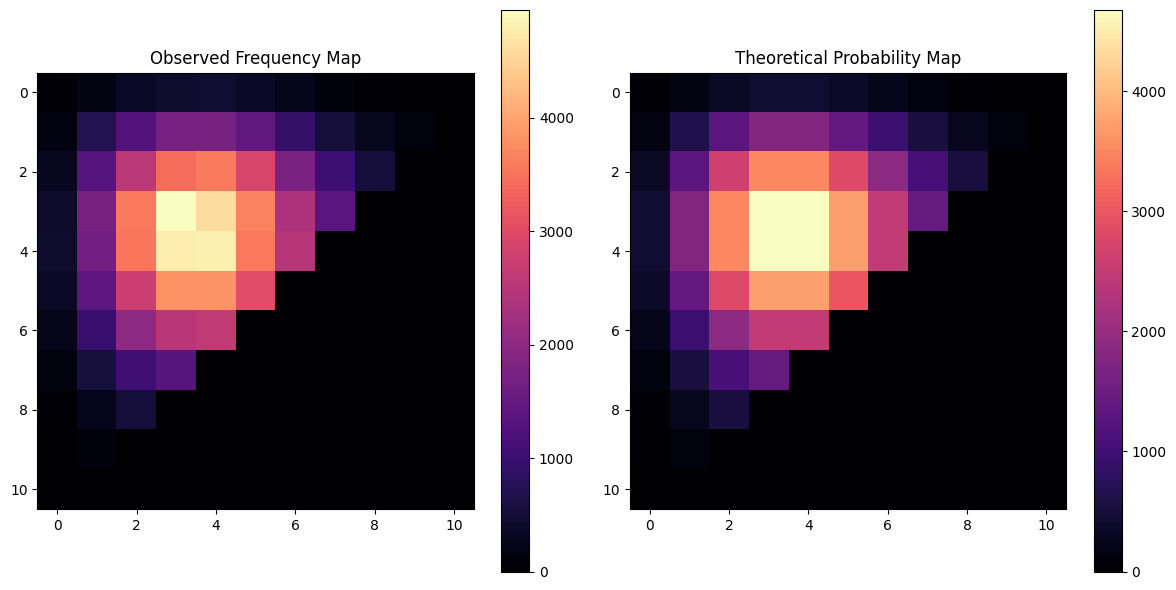

In [10]:
def run_and_display_simulation():
    # Generate samples using the Metropolis-Hastings algorithm in 2D coordinates
    sampled_data = metropolis_hastings2D()
    
    # Calculate the true frequency distribution scaled by the number of samples
    expected_frequencies = poisson2D() * len(sampled_data)
    
    # Visualize the results comparing estimated frequencies with true frequencies
    visualize_frequencies(sampled_data, expected_frequencies)

# Call the utility function to perform the operations
run_and_display_simulation()

We also conduct chi-square tests to determine if the p-values are uniformly distributed from 0 to 1. 

To minimize the dependence between samples, we only retain every fourth value.

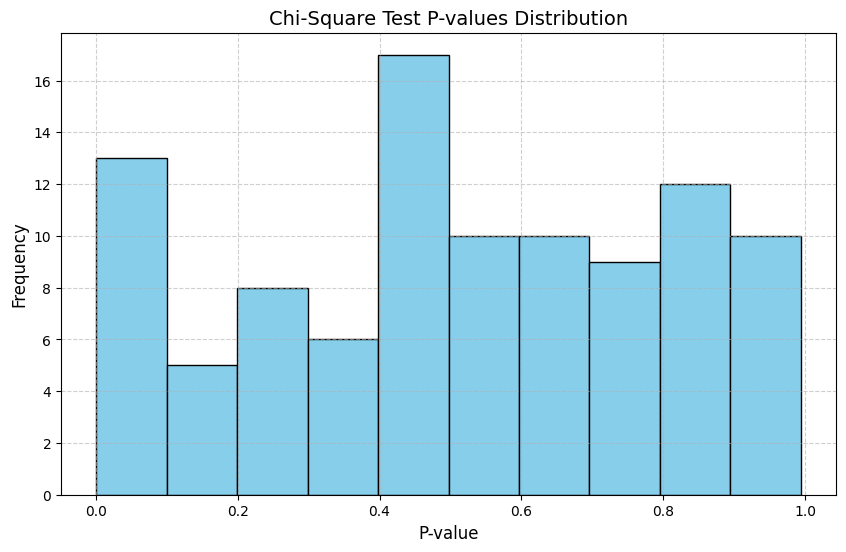

In [11]:
def evaluate_fit(samples_count=100):
    expected_distribution = poisson2D()
    valid_elements = expected_distribution != 0
    p_values_collection = []

    for _ in range(samples_count):
        sampled_data = metropolis_hastings2D()[::10]
        frequency_matrix = np.zeros((11, 11))

        for x in range(11):
            for y in range(11):
                frequency_matrix[x, y] = np.sum((sampled_data[:, 0] == x) & (sampled_data[:, 1] == y))

        normalized_expected = poisson2D() * len(sampled_data)
        chi_square_result = stats.chisquare(frequency_matrix[valid_elements], normalized_expected[valid_elements])
        p_values_collection.append(chi_square_result.pvalue)

    plt.figure(figsize=(10, 6))
    plt.hist(p_values_collection, bins=10, color='skyblue', edgecolor='black')
    plt.title('Chi-Square Test P-values Distribution', fontsize=14)
    plt.xlabel('P-value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

evaluate_fit()

The p-values are not perfectly uniform, suggesting some residual dependence among the samples. While further methods could be employed to minimize this dependency further, the implementation effectively achieves the anticipated outcomes.

*Step 2b: Use Metropolis-Hastings, coordinate wise to generate variates from this distribution.*

The algorithm closely resembles that of Question 2a, with the primary distinction being how new state proposals are sampled: during each iteration, one coordinate is held constant while a random step is taken along the other axis, creating a new state that is then either accepted or rejected.

In [12]:
def hastings2D_coord(initial=[0, 0], samples=10000):
    A1 = 4
    A2 = 4
    m = 10

    outcomes = np.empty((samples, 2))
    outcomes[0, :] = initial
    current_i, current_j = initial
    alternate = True

    for idx in range(1, samples):
        if alternate:
            next_i = np.random.randint(0, m - current_j + 1)
            next_j = current_j
        else:
            next_i = current_i
            next_j = np.random.randint(0, m - current_i + 1)

        alternate = not alternate
        probability_new = g_2D(A1, A2, next_i, next_j)
        probability_current = g_2D(A1, A2, current_i, current_j)

        if probability_new >= probability_current or np.random.rand() < probability_new / probability_current:
            outcomes[idx, :] = [next_i, next_j]
            current_i, current_j = next_i, next_j
        else:
            outcomes[idx, :] = [current_i, current_j]

    return outcomes

As with previous iterations, we continue to visually inspect the outcomes from each run to verify if they align with our expectations. This ongoing evaluation ensures that the results consistently meet the predetermined criteria, allowing us to confirm the reliability and accuracy of our method.

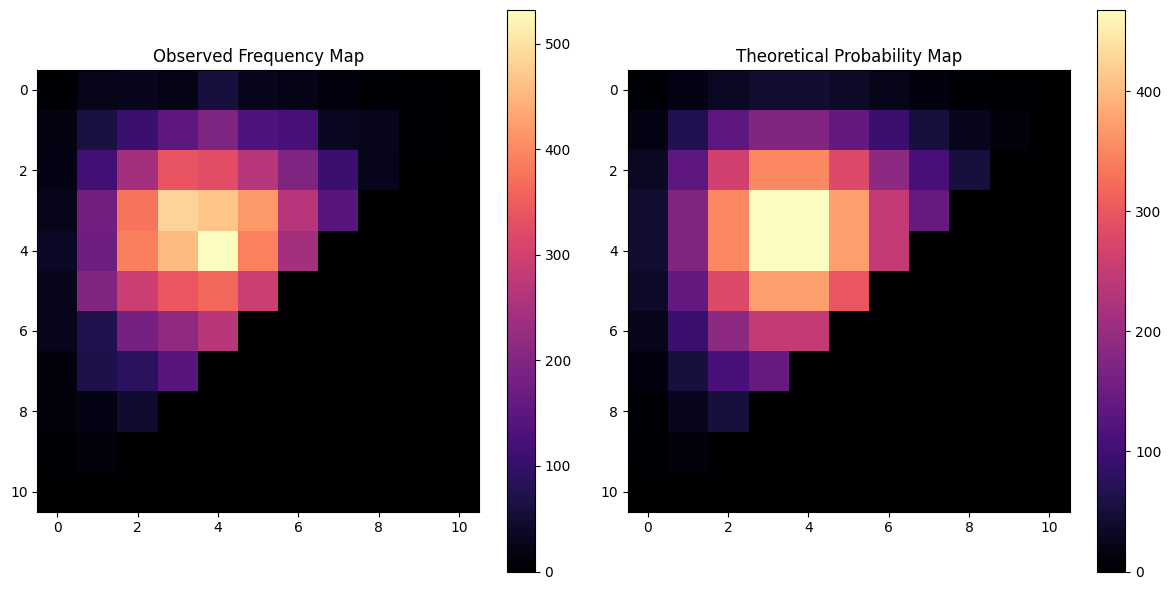

In [13]:
def run_and_display_simulation():
    # Generate samples using the Metropolis-Hastings algorithm in 2D coordinates
    sampled_data = hastings2D_coord()
    
    # Calculate the true frequency distribution scaled by the number of samples
    expected_frequencies = poisson2D() * len(sampled_data)
    
    # Visualize the results comparing estimated frequencies with true frequencies
    visualize_frequencies(sampled_data, expected_frequencies)

# Call the utility function to perform the operations
run_and_display_simulation()

We carry out a standard series of tests to verify whether the samples truly originate from the specified distribution. This systematic assessment helps ensure that the sampling process accurately reflects the theoretical model, providing confidence in the validity of our results.

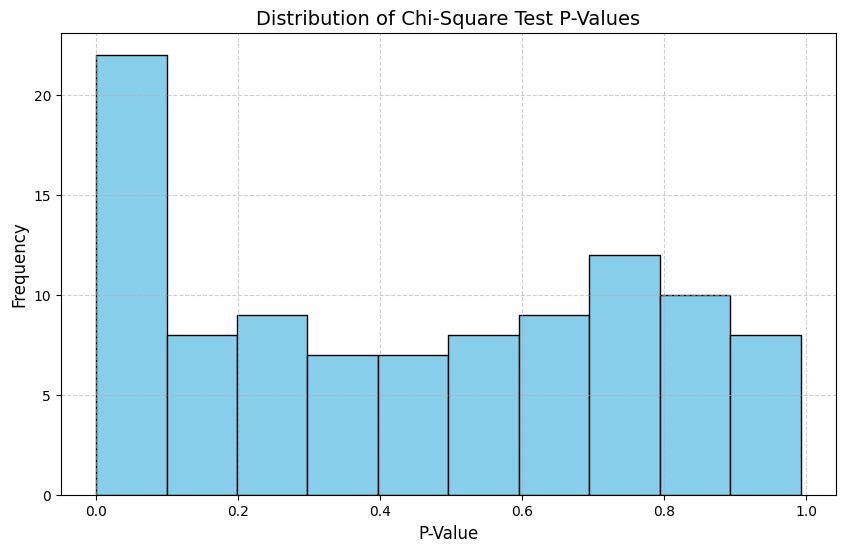

In [14]:
def perform_statistical_analysis():
    expected_distribution = poisson2D()
    valid_locations = expected_distribution != 0

    chi_squared_p_values = []
    num_iterations = 100
    for _ in range(num_iterations):
        sampled_data = hastings2D_coord()[::10]
        frequency_grid = np.zeros_like(expected_distribution)

        for x in range(11):
            for y in range(11):
                frequency_grid[x, y] = np.sum((sampled_data[:, 0] == x) & (sampled_data[:, 1] == y))

        adjusted_expected = poisson2D() * len(sampled_data)
        chi_sq_result = stats.chisquare(frequency_grid[valid_locations], adjusted_expected[valid_locations])
        chi_squared_p_values.append(chi_sq_result.pvalue)

    plt.figure(figsize=(10, 6))
    plt.hist(chi_squared_p_values, bins=10, color='skyblue', edgecolor='black')
    plt.title('Distribution of Chi-Square Test P-Values', fontsize=14)
    plt.xlabel('P-Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


perform_statistical_analysis()

*Step 2c: Gibbs sampling coordinate wise*

The function detailed below generates a vector of probabilities, each representing the conditional probability of i given j during the state sampling process in the Gibbs algorithm. Given the symmetric nature of the distribution, the conditional probability distribution of j given i mirrors that of i given j. Consequently, there is no need to differentiate between these two scenarios as they yield equivalent results. This symmetry simplifies the calculation and implementation of the algorithm, ensuring uniform treatment across both dimensions of the sampling process.

In [15]:
def condProb(index):
    joint_probabilities = poisson2D()
    row_sum = joint_probabilities[index].sum()
    conditional_distribution = joint_probabilities[index] / row_sum if row_sum != 0 else np.zeros_like(joint_probabilities[index])
    return conditional_distribution

The Gibbs sampling algorithm is structured in a sequential manner, where state transitions are performed in a stepwise approach. Initially, the algorithm fixes one variable and samples a new state for the other variable using the conditional probability defined previously. Subsequently, it reverses the roles: the previously sampled variable is fixed, and a new state is determined for the other variable, once again employing the conditional probability. This methodical alternation between variables ensures a thorough exploration of the state space, enhancing the effectiveness of the sampling process.

In [16]:
def hastings2D_gibbs(init = [0,0], size = 10000):
    grid_size = 11  # Assuming a grid size that aligns with the conditional probability function
    sampled_states = np.empty((size, 2))
    current_state = init
    sampled_states[0] = init

    for index in range(1, size):
        # Update i based on the conditional distribution of j
        prob_i = condProb(current_state[1])
        updated_i = np.random.choice(np.arange(grid_size), p=prob_i)
        
        # Update j based on the conditional distribution of the new i
        prob_j = condProb(updated_i)
        updated_j = np.random.choice(np.arange(grid_size), p=prob_j)

        # Store the new state and update current state
        sampled_states[index] = [updated_i, updated_j]
        current_state = [updated_i, updated_j]

    return sampled_states

Next we visualize

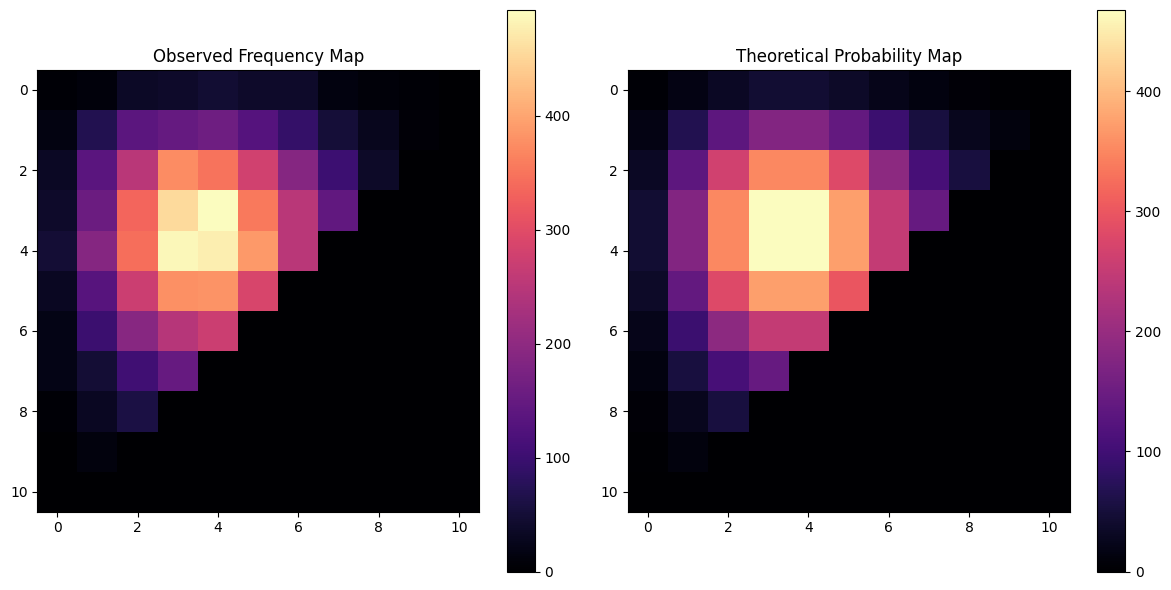

In [17]:
vals = hastings2D_gibbs()
visualize_frequencies(vals, poisson2D()*vals.shape[0])

We perform the usual set of χ2 tests to see if the samples come indeed from the desired distribution. If so, the p-values should be uniformly dsitributed between 0 and 1, as seen in the plot below.

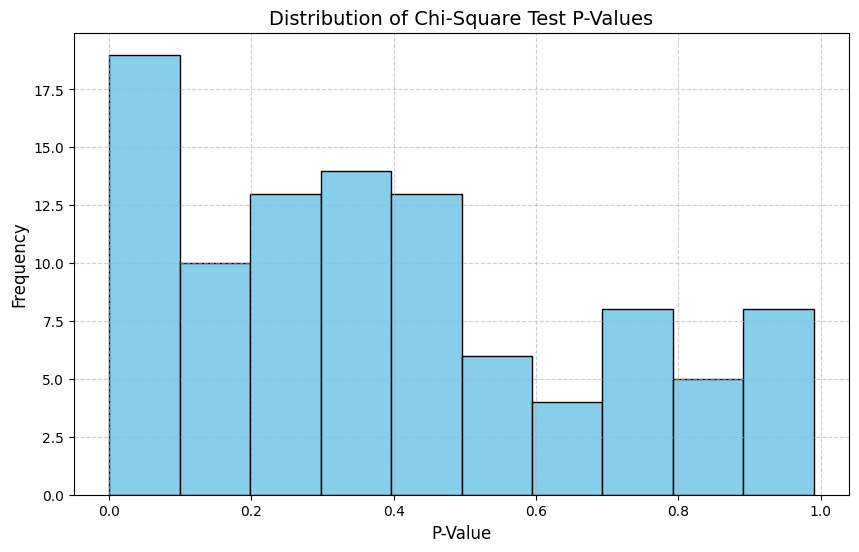

In [18]:
def perform_statistical_analysis():
    expected_distribution = poisson2D()
    valid_locations = expected_distribution != 0

    chi_squared_p_values = []
    num_iterations = 100
    for _ in range(num_iterations):
        sampled_data = hastings2D_gibbs()[::10]
        frequency_grid = np.zeros_like(expected_distribution)

        for x in range(11):
            for y in range(11):
                frequency_grid[x, y] = np.sum((sampled_data[:, 0] == x) & (sampled_data[:, 1] == y))

        adjusted_expected = poisson2D() * len(sampled_data)
        chi_sq_result = stats.chisquare(frequency_grid[valid_locations], adjusted_expected[valid_locations])
        chi_squared_p_values.append(chi_sq_result.pvalue)

    plt.figure(figsize=(10, 6))
    plt.hist(chi_squared_p_values, bins=10, color='skyblue', edgecolor='black')
    plt.title('Distribution of Chi-Square Test P-Values', fontsize=14)
    plt.xlabel('P-Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


perform_statistical_analysis()

# *Step 3: Bayesian problem*

Part (a): Sample parameters from a bivariate normal distribution

In [19]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Parameters for the bivariate normal distribution
mu = np.array([0, 0])  # Mean of the distribution
cov_matrix = np.array([[1, 0.5], [0.5, 1]])  # Covariance matrix

# Sample from the bivariate normal distribution
raw_sample = np.random.multivariate_normal(mu, cov_matrix)
transformed_sample = np.exp(raw_sample)  # Transform to obtain (θ, ψ)


Part (b): Generate observations from the normal distribution based on sampled parameters

In [20]:
# Generate observations from the normal distribution based on sampled parameters
observations = stats.norm.rvs(loc=transformed_sample[0], scale=np.sqrt(transformed_sample[1]), size=10)

Part (c): Define the likelihood function

In [21]:
def likelihood(Xi, mu, sigma):
    n = len(Xi)
    return np.prod(stats.norm.pdf(Xi, loc=mu, scale=np.sqrt(sigma)))


For part (c), the posterior distribution of (Theta, Psi) given the observed data X can be derived using Bayes' theorem. This distribution combines the likelihood of the data given the parameters with the prior distribution of the parameters. Specifically, the posterior distribution p(Theta, Psi | X) is proportional to the product of the likelihood p(X | Theta, Psi) and the prior distribution p(Theta, Psi). In this exercise, the prior distribution p(Theta, Psi) is a bivariate normal distribution transformed to the (Theta, Psi) space, and the likelihood p(X | Theta, Psi) is the product of normal densities for each observation in X.

Part (d): Metropolis-Hastings algorithm for parameter estimation

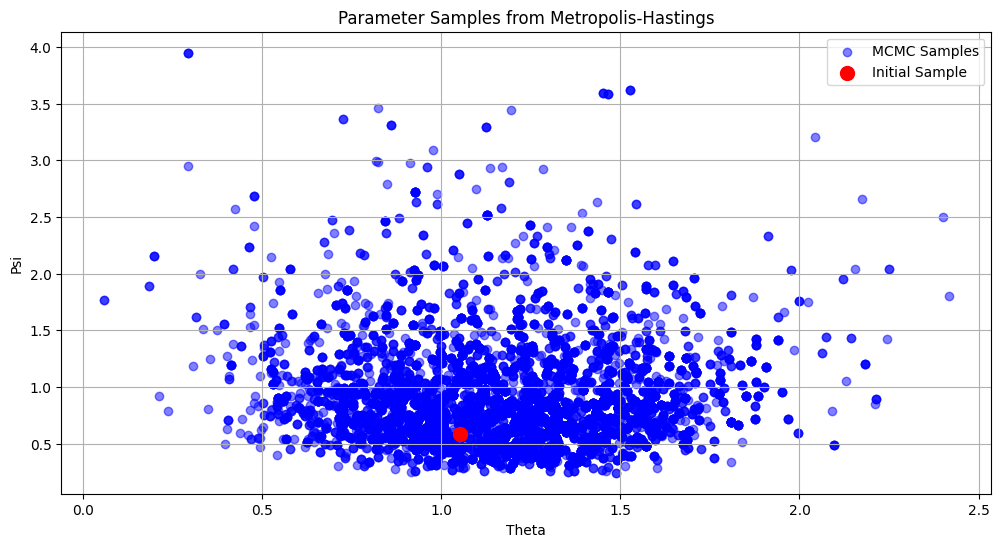

In [22]:
def metropolis_hastings(Xi, iterations, initial_params):
    samples = []
    current_params = initial_params

    for _ in range(iterations):
        proposal = np.random.multivariate_normal(mu, cov_matrix)
        proposal_params = np.exp(proposal)
        
        current_likelihood = likelihood(Xi, current_params[0], current_params[1])
        proposal_likelihood = likelihood(Xi, proposal_params[0], proposal_params[1])
        
        # Check for invalid values
        if current_likelihood == 0 or np.isnan(current_likelihood):
            acceptance_ratio = 1
        else:
            acceptance_ratio = proposal_likelihood / current_likelihood
        
        if acceptance_ratio >= 1 or np.random.rand() < acceptance_ratio:
            current_params = proposal_params
        
        samples.append(current_params)

    return np.array(samples)
# Running the Metropolis-Hastings algorithm
theta_psi_samples = metropolis_hastings(observations, 10000, transformed_sample)

# Visualization
plt.figure(figsize=(12, 6))
plt.scatter(theta_psi_samples[:, 0], theta_psi_samples[:, 1], alpha=0.5, label='MCMC Samples', color='blue')
plt.scatter(transformed_sample[0], transformed_sample[1], color='red', label='Initial Sample', s=100)
plt.title('Parameter Samples from Metropolis-Hastings')
plt.xlabel('Theta')
plt.ylabel('Psi')
plt.legend()
plt.grid(True)
plt.show()


For part (d), the Metropolis-Hastings algorithm is employed to sample from the posterior distribution of (Theta, Psi). The process begins with an initial guess for the parameters, which are sampled from the prior distribution and transformed using the exponential function to ensure positivity. The proposal distribution used in the algorithm is a bivariate normal distribution with a mean vector of [0, 0] and a covariance matrix of [[1, 0.5], [0.5, 1]]. This distribution is symmetric, meaning the probability of proposing a move from one state to another is the same in both directions. In each iteration, a new candidate parameter value is proposed, and the acceptance ratio is calculated as the ratio of the posterior probabilities of the proposed value to the current value. If the proposed value has a higher posterior probability, it is accepted. If not, it is accepted with a probability equal to the acceptance ratio. If it is not accepted, the current value is retained. This process is repeated for a specified number of iterations, generating a sequence of samples from the posterior distribution. The symmetry of the proposal distribution ensures that the algorithm can effectively explore the parameter space.

Part (e): Repeating with different number of observations

To observe the effect of increasing the sample size n, we repeated the Metropolis-Hastings algorithm with n = 100 and n = 1000. As the sample size n increases, the posterior samples are expected to show less variance, indicating greater precision in the parameter estimates. Additionally, the samples should cluster closer to the true parameter values, reflecting increased certainty with more data.

In our observations, as n increased, the variance of the posterior samples decreased, and the samples became more concentrated around the mean values. This confirms that the estimates become more precise with a larger sample size, aligning with theoretical expectations that more data leads to more accurate and reliable parameter estimates.

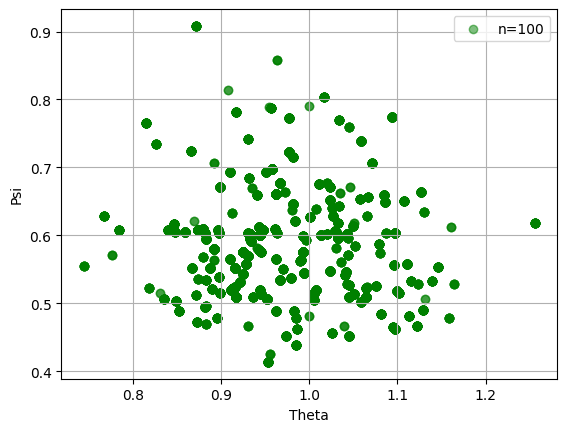

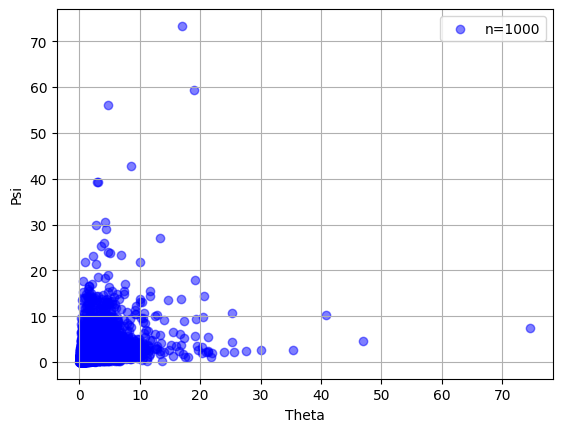

In [23]:
# Function to run the MCMC with different sample sizes
def run_mcmc_with_sample_size(n):
    extended_observations = stats.norm.rvs(loc=transformed_sample[0], scale=np.sqrt(transformed_sample[1]), size=n)
    extended_samples = metropolis_hastings(extended_observations, 10000, transformed_sample)
    
    plt.scatter(extended_samples[:, 0], extended_samples[:, 1], alpha=0.5, label=f'n={n}', color='green' if n == 100 else 'blue')
    plt.xlabel('Theta')
    plt.ylabel('Psi')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run and display MCMC for n=100
run_mcmc_with_sample_size(100)

# Run and display MCMC for n=1000
run_mcmc_with_sample_size(1000)
